In [50]:
!pip install split-folders

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [51]:
!featurize dataset download 73133c92-3155-40f5-aaeb-6447bb312ad0

100%|████████████████████████████████████████| 688M/688M [00:02<00:00, 237MiB/s]
🍬  下载完成，正在解压...
🏁  数据集已经成功添加


In [52]:
import splitfolders
splitfolders.ratio(input='data/animals', output='data/animals1', seed=1337, ratio=(0.6, 0.2, 0.2))

Copying files: 5400 files [00:02, 2087.14 files/s]


In [53]:
!pip install fastai

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [54]:
from fastai.vision.all import *

In [55]:
path = Path('data/animals1')

In [56]:
item_tfms = Resize(224)

In [57]:
batch_tfms = aug_transforms()

In [58]:
dls = ImageDataLoaders.from_folder(
    path,
    train = 'train',
    valid = 'val',
    seed = 42,
    bs=32,
    item_tfms = item_tfms,
    batch_tfms = batch_tfms)

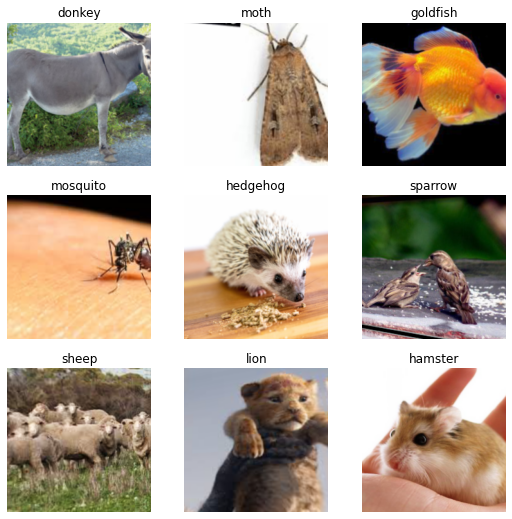

In [59]:
dls.show_batch()

In [60]:
arch = resnet18

In [61]:
learn1 = vision_learner(dls, arch, metrics=accuracy)

In [62]:
from fastai.callback.tracker import EarlyStoppingCallback,SaveModelCallback

In [63]:
save_model_cb =SaveModelCallback()
early_stop_cb = EarlyStoppingCallback

In [64]:
learn1.fine_tune(20, 3e-3,cbs=[early_stop_cb,save_model_cb])

epoch,train_loss,valid_loss,accuracy,time
0,2.600230,0.809187,0.756481,00:21


Better model found at epoch 0 with valid_loss value: 0.8091870546340942.


epoch,train_loss,valid_loss,accuracy,time
0,0.945628,0.530028,0.851852,00:21
1,0.699652,0.465787,0.871296,00:21
2,0.568690,0.468845,0.867593,00:21


Better model found at epoch 0 with valid_loss value: 0.5300283432006836.
Better model found at epoch 1 with valid_loss value: 0.46578726172447205.
No improvement since epoch 1: early stopping


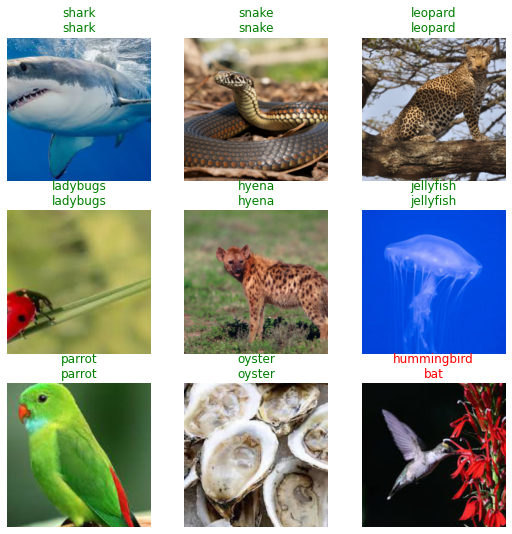

In [65]:
learn1.show_results()

In [66]:
interp = ClassificationInterpretation.from_learner(learn1)

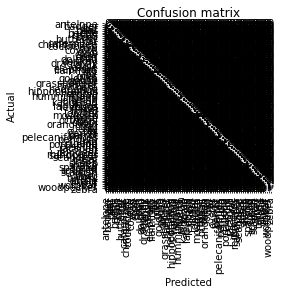

In [67]:
interp.plot_confusion_matrix()

In [68]:
interp.print_classification_report()

                precision    recall  f1-score   support

      antelope       1.00      0.75      0.86        12
        badger       1.00      1.00      1.00        12
           bat       0.73      0.67      0.70        12
          bear       1.00      0.67      0.80        12
           bee       0.91      0.83      0.87        12
        beetle       0.89      0.67      0.76        12
         bison       0.92      0.92      0.92        12
          boar       0.92      0.92      0.92        12
     butterfly       0.91      0.83      0.87        12
           cat       0.91      0.83      0.87        12
   caterpillar       0.91      0.83      0.87        12
    chimpanzee       1.00      0.67      0.80        12
     cockroach       1.00      0.92      0.96        12
           cow       0.78      0.58      0.67        12
        coyote       0.86      0.50      0.63        12
          crab       0.85      0.92      0.88        12
          crow       1.00      0.92      0.96  

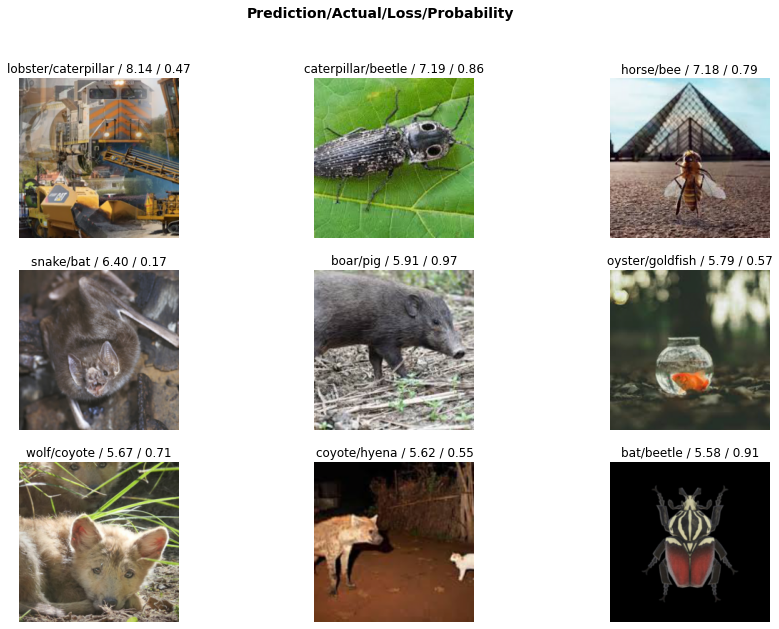

In [69]:
interp.plot_top_losses(9, figsize=(15,10))

In [70]:
test_dl = dls.test_dl(get_image_files(path/'test'),
                      with_labels=True)

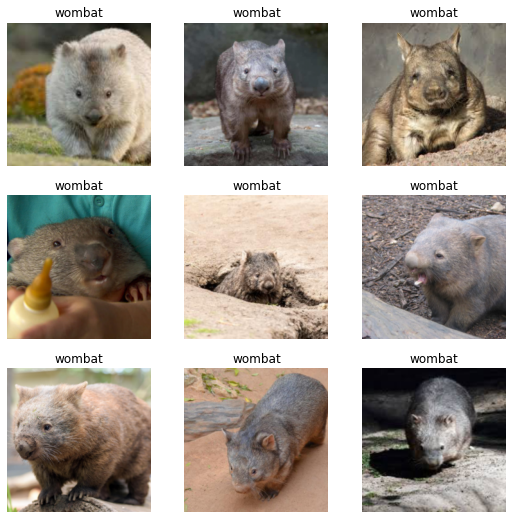

In [71]:
test_dl.show_batch()

In [72]:
preds, targets = learn1.get_preds(dl=test_dl)

In [73]:
preds

tensor([[5.1572e-07, 1.1622e-04, 4.1177e-06,  ..., 9.8972e-01, 6.9870e-06,
         1.7752e-05],
        [9.5746e-09, 1.2898e-05, 7.7627e-07,  ..., 9.9916e-01, 1.2199e-08,
         7.9254e-08],
        [8.4141e-05, 4.3028e-04, 1.1416e-03,  ..., 7.2957e-01, 1.1586e-05,
         5.3426e-05],
        ...,
        [1.5912e-03, 3.7394e-04, 1.2177e-03,  ..., 1.1916e-02, 2.7881e-04,
         1.6241e-03],
        [3.3654e-05, 2.4262e-04, 4.2850e-05,  ..., 6.2609e-04, 4.4643e-04,
         2.7237e-05],
        [5.9151e-04, 4.1088e-05, 2.7107e-04,  ..., 1.1434e-03, 2.1712e-05,
         2.6581e-04]])

In [74]:
targets

tensor([87, 87, 87,  ..., 79, 79, 79])

In [75]:
from fastai.tabular.all import *

In [76]:
accuracy(preds, targets)

TensorBase(0.8657)

In [77]:
interp = ClassificationInterpretation.from_learner(learn1, 
                                                   dl=test_dl)

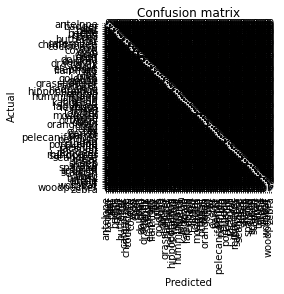

In [78]:
interp.plot_confusion_matrix()

In [79]:
interp.print_classification_report()

                precision    recall  f1-score   support

      antelope       0.92      0.92      0.92        12
        badger       1.00      0.83      0.91        12
           bat       0.73      0.67      0.70        12
          bear       0.85      0.92      0.88        12
           bee       1.00      0.75      0.86        12
        beetle       0.83      0.83      0.83        12
         bison       1.00      0.75      0.86        12
          boar       0.85      0.92      0.88        12
     butterfly       1.00      0.92      0.96        12
           cat       1.00      0.83      0.91        12
   caterpillar       0.83      0.83      0.83        12
    chimpanzee       0.89      0.67      0.76        12
     cockroach       0.92      0.92      0.92        12
           cow       0.91      0.83      0.87        12
        coyote       0.88      0.58      0.70        12
          crab       0.86      1.00      0.92        12
          crow       1.00      0.83      0.91  

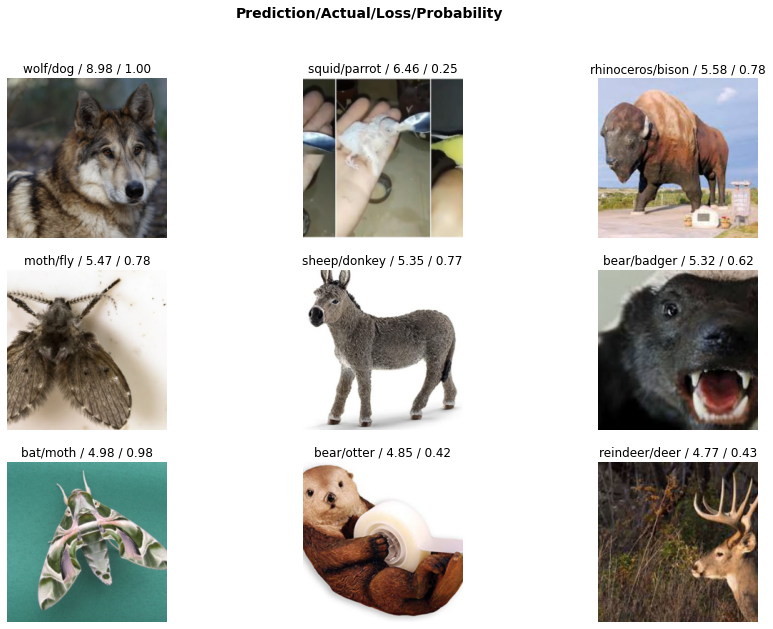

In [80]:
interp.plot_top_losses(9, figsize=(15,10))

In [81]:
import fastai.vision.all as fv
import matplotlib.pyplot as plt
import cv2
import torch

def grad_cam(learn, img_path, layer_name=None):
    img = fv.PILImage.create(img_path)
    x = fv.tensor(img).float() / 255.
    x = x.permute(2, 0, 1)  # Rearrange dimensions to (channels, height, width)
    xb = x.unsqueeze(0).cuda()
    learn.model.eval()

    if layer_name is None:
        layer_name = learn.model[0][-2]

    hook_output = []
    hook = fv.hook_output(layer_name)

    output = learn.model(xb)
    preds = torch.softmax(output, dim=1)
    class_idx = preds.argmax(dim=1).item()

    one_hot = torch.zeros_like(output)
    one_hot[0, class_idx] = 1.0

    # Clear gradients before backward pass
    learn.model.zero_grad()

    # Perform backward pass with one_hot tensor as the gradient
    output.backward(gradient=one_hot)

    grads = hook.stored[0]
    weights = grads.mean(dim=[1, 2], keepdim=True)
    cam_map = (weights * hook.stored[0]).sum(dim=0)
    cam_map = torch.relu(cam_map).cpu().detach().numpy()


    # Normalize the CAM map
    cam_map = (cam_map - cam_map.min()) / (cam_map.max() - cam_map.min())

    # Resize the CAM map to the original image size and apply a colormap
    cam_map_resized = cv2.resize(cam_map, (img.width, img.height))
    heatmap = cv2.applyColorMap((cam_map_resized * 255).astype('uint8'), cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image with an opacity of 0.5
    result = cv2.addWeighted(np.array(img), 0.5, heatmap, 0.5, 0)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(cam_map, alpha=0.5, cmap='jet', interpolation='bilinear', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(learn.dls.vocab[class_idx])
    plt.show()

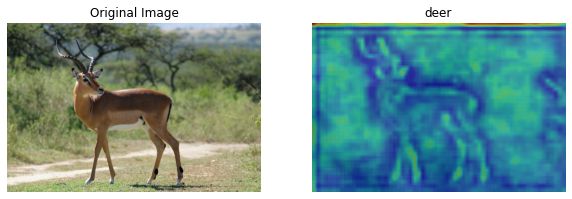

In [82]:
grad_cam(learn1, "data/animals1/test/antelope/0fe7076f06.jpg")

In [83]:
!pip install torchcam

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [84]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp

# model = learn.model.eval()
model = resnet18(pretrained=True).eval()

In [85]:
img = read_image("data/animals1/test/antelope/0fe7076f06.jpg")

In [86]:
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# Enable gradients for the input tensor
# input_tensor.requires_grad = True
# Create a SmoothGradCAMpp instance without using 'with' statement
cam_extractor = SmoothGradCAMpp(model)

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

# # Don't forget to clean up the hooks after using the cam_extractor
# cam_extractor.clear_hooks()

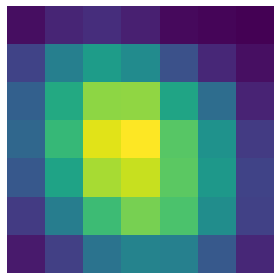

In [87]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

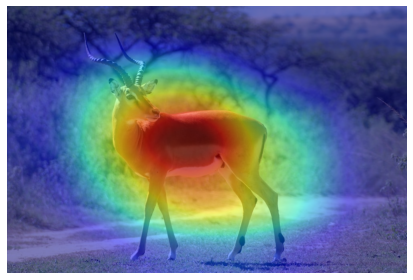

In [88]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

In [91]:
learn1.export(fname='export.pkl')